# Проект: классификация

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

Данные о клиентах банка:

 - age (возраст);
 - job (сфера занятости);
 - marital (семейное положение);
 - education (уровень образования);
 - default (имеется ли просроченный кредит);
 - housing (имеется ли кредит на жильё);
 - loan (имеется ли кредит на личные нужды);
 - balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

 - contact (тип контакта с клиентом);
 - month (месяц, в котором был последний контакт);
 - day (день, в который был последний контакт);
 - duration (продолжительность контакта в секундах).

Прочие признаки:

 - campaign (количество контактов с этим клиентом в течение текущей кампании);
 - pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
 - previous (количество контактов до текущей кампании)
 - poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [2]:
df = pd.read_csv('bank_fin.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()
# пропущенные значения в столбце balance - 25

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.unique()
# пропуски закодированы как 'unknown'

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df_1 = df.copy()

# функция для преобразования признака balance
def to_float(x):
    if type(x) == str:
        return float(x.replace('$', '').replace(',', '.').replace(' ', ''))

# применяем функцию 
df_1['balance'] = df_1['balance'].apply(to_float)
round(df_1['balance'].mean(), 3)

1529.129

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
# вычисляем медиану признака
median_balance = df_1['balance'].median()

# заполняем пропуски медианой
df_1['balance'] = df_1['balance'].fillna(median_balance)
round(df_1['balance'].mean(), 3)

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df_2 = df_1.copy()
# вычисляем моду признака
mode_job = df_2['job'].mode()[0]
mode_education = df_2['education'].mode()[0]

# заполняем пропуски модой
df_2['job'] = df_2['job'].apply(lambda x: mode_job if x == 'unknown' else x)
df_2['education'] = df_2['education'].apply(
    lambda x: mode_education if x == 'unknown' else x)

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [8]:
# средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
round(df_2[(df_2['job'] == mode_job) & (
    df_2['education'] == mode_education)]['balance'].mean(), 3)

1598.883

### Задание 6

Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха (Q1−1.5∗IQR) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (Q3+1.5∗IQR). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

Примечание. Несмотря на то что существуют более продвинутые методы поиска аномальных значений, для обработки одного числового признака достаточно хорошо подходит метод Тьюки. После решения задачи вы сможете попробовать применить и другие методы, оценив их влияние на качество поиска.

In [9]:
# удалите все выбросы для признака balance
# ваш код

# Функция для поиска выбросов с помощью метода Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print(round(lower_bound))
    upper_bound = quartile_3 + (iqr * 1.5)
    print(round(upper_bound))
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# применяем функцию 
outliers, df_3 = outliers_iqr(df_2, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_3.shape[0]}')

-2241
4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Дополнительное задания 

На этапе №2, после выполнения задания 2.6, применить новый подход для поиска аномальных значений в данных (помимо метода предложенного в пункте 2.6). В тетради с реализацией модели сравнить полученные результаты с базовой моделью.

In [10]:
# Поиск выбросов и аномалий с помощью DBSCAN

# столбец для поиска выбросов
column_data = df_2['balance'].values.reshape(-1, 1)

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
outlier_labels = dbscan.fit_predict(column_data)

# Получаем индексы выбросов
outlier_indices = np.where(outlier_labels == -1)[0]

# Выводим индексы выбросов
print("Выбросы в столбце баланса:", len(outlier_indices))

Выбросы в столбце баланса: 5338


In [11]:
# Поиск выбросов с помощью метода z-отклонений

def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(df_2, 'balance', log_scale=False)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 173
Результирующее число записей: 10989


Вывод: больше всего выбросов найдено с помощью метода DBSCAN - 5338, в меоде z-отклонений - 173 выбросов, а по методу Тьюки - 1057. Результаты сильно разнородные. Модель DBSCAN скорее всео дает менее надежные результаты в данном случае и это связано с тем, что мы не подбирали гиперпараметры, а установленные для примера значения параметров не подходят под наши данные. 



## Часть 2:  Разведывательный анализ

### Задание 1

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df_3['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

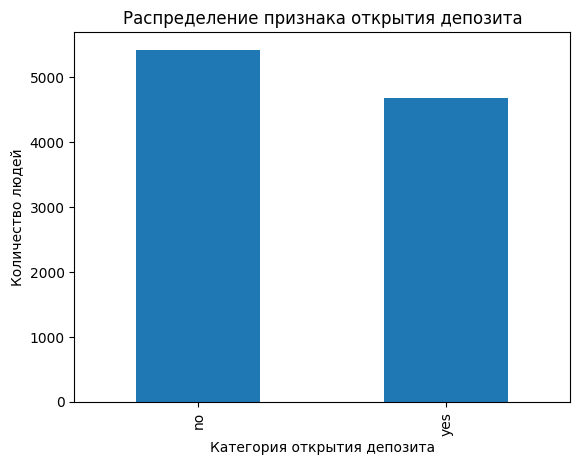

In [13]:
df_3['deposit'].value_counts().plot(kind='bar')
plt.xlabel('Категория открытия депозита')
plt.ylabel('Количество людей')
plt.title('Распределение признака открытия депозита')

plt.show()

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Максимальный возраст клиентов: 95
Минимальная продолжительность разговора с клиентом: 2


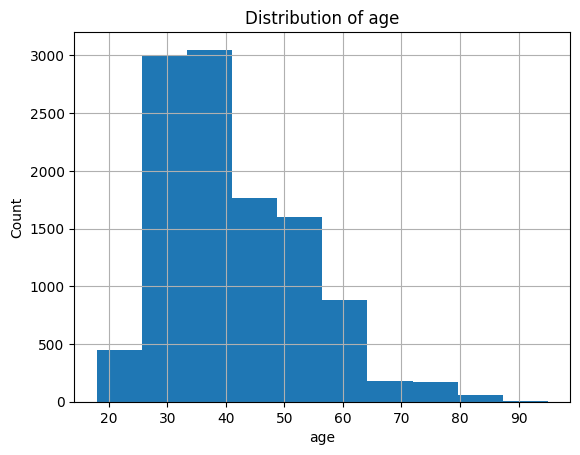

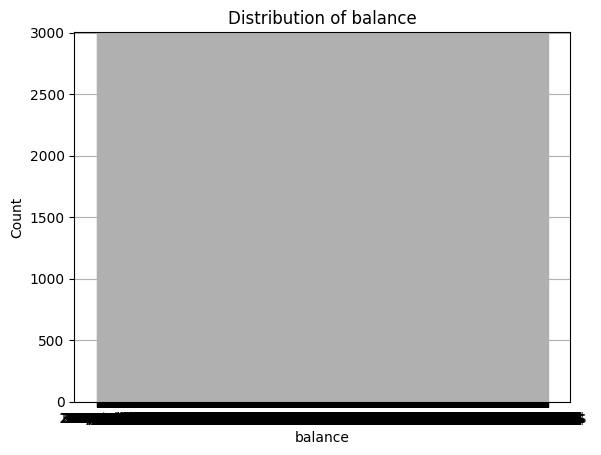

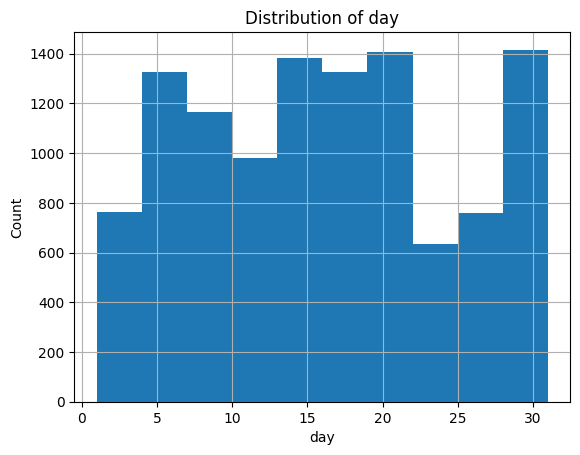

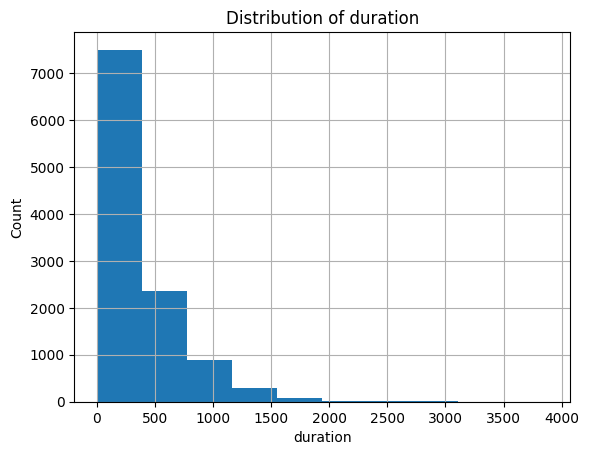

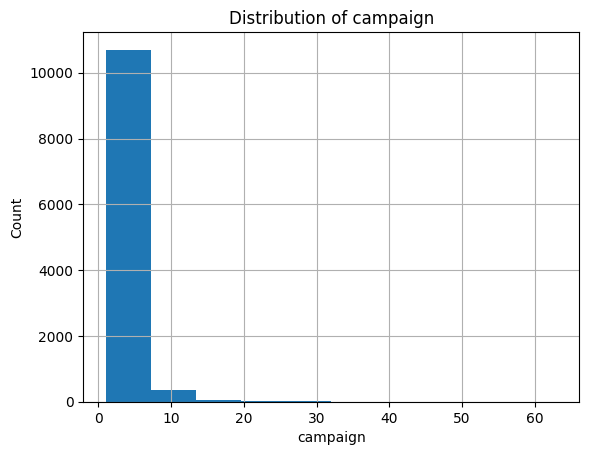

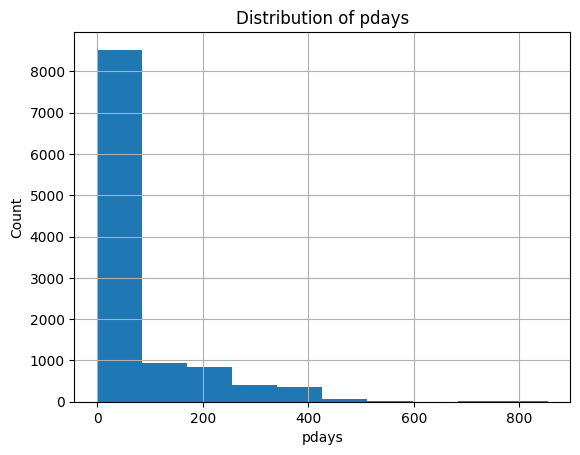

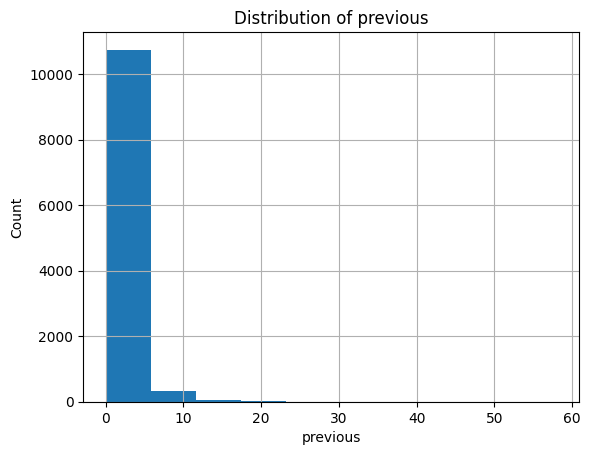

In [14]:
# рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
# ваш код
display(df_3.describe())

print(f'Максимальный возраст клиентов: {df_3["age"].max()}')
print(
    f'Минимальная продолжительность разговора с клиентом: {df_3["duration"].min()}')

# построение графиков распределения количественных признаков
num_cols = df_3.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col].hist()
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.show()

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Количество месяцев рекламной кампании: 10105
Количество сфер занятости среди клиентов : 11


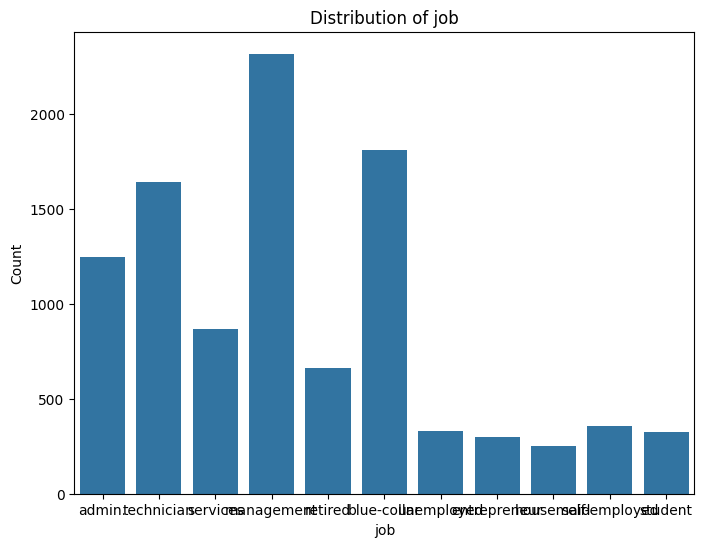

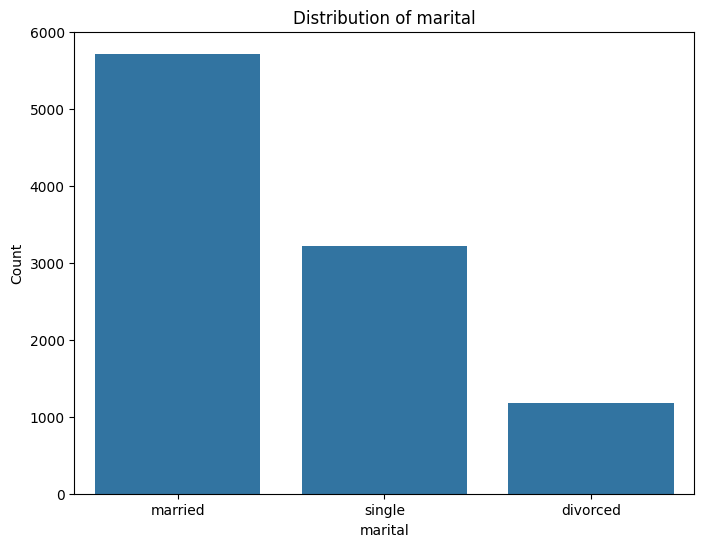

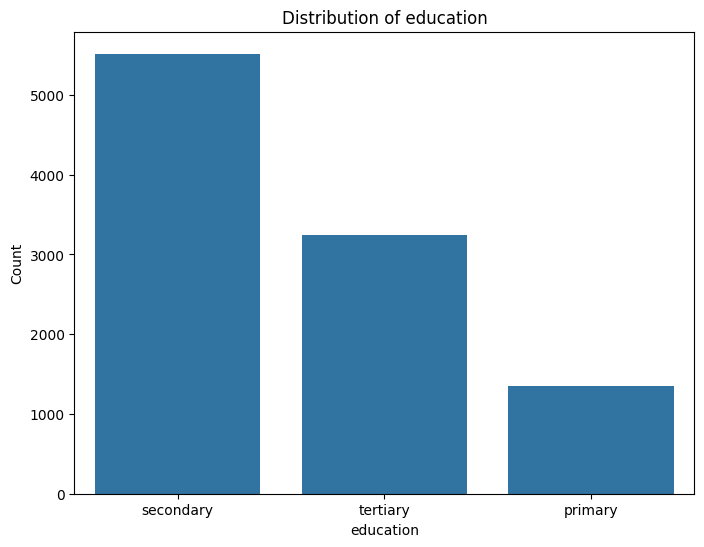

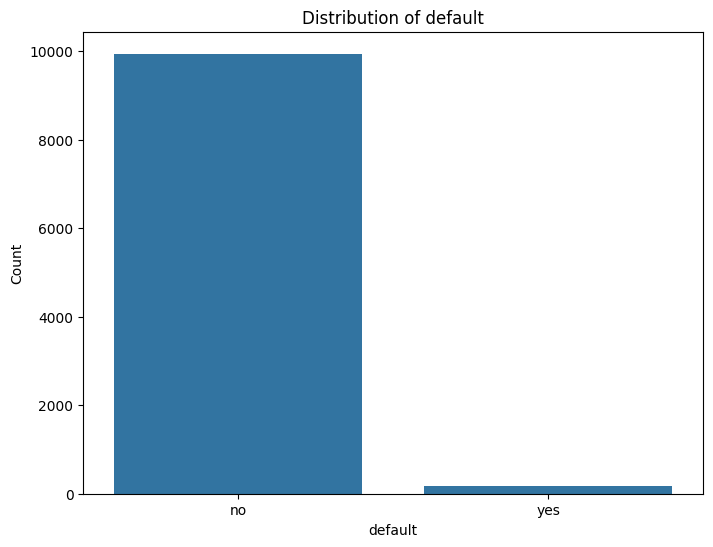

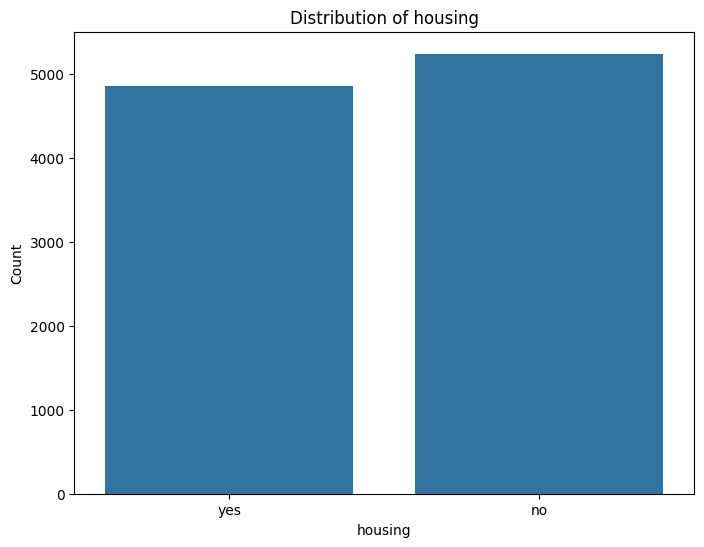

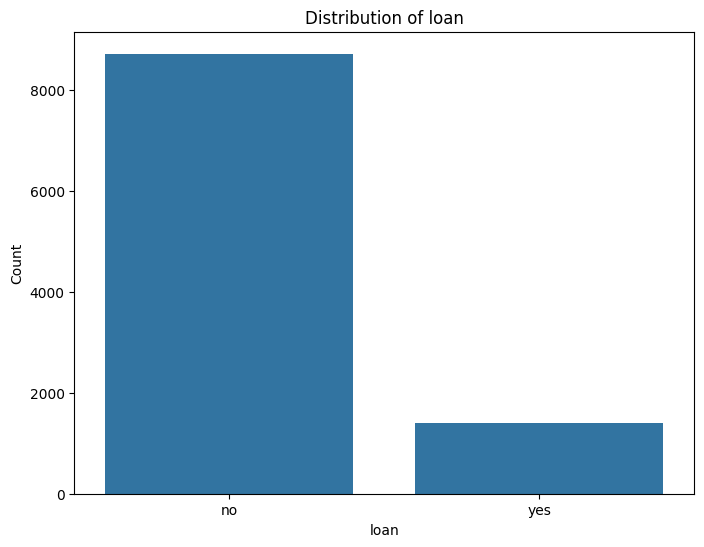

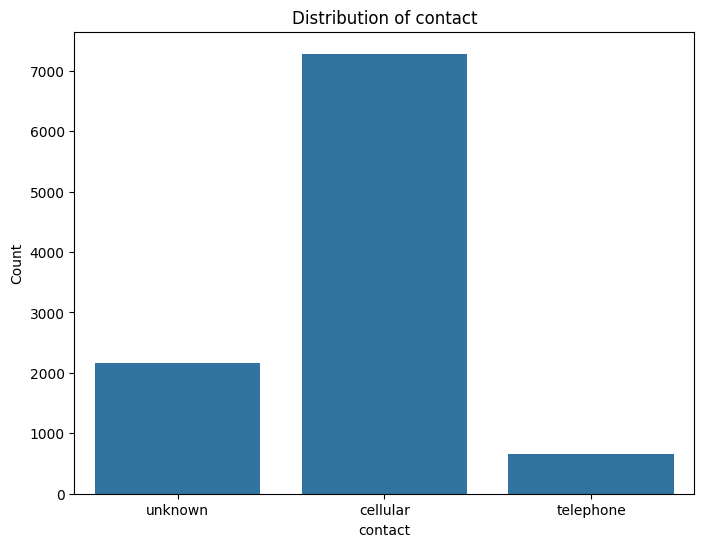

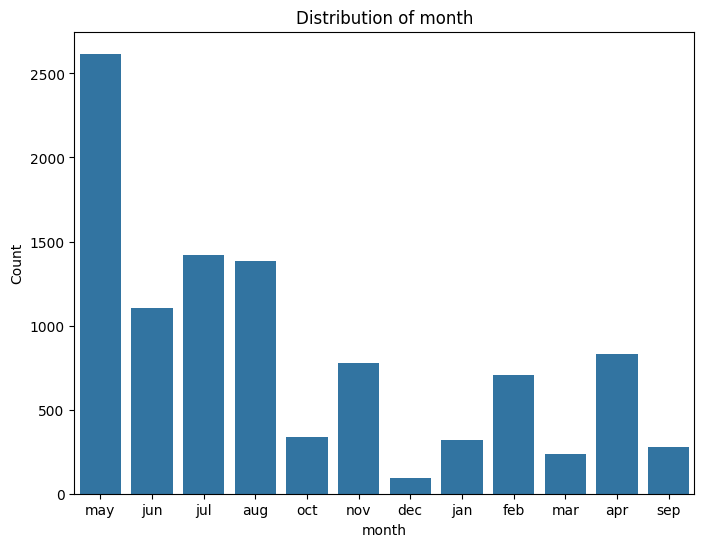

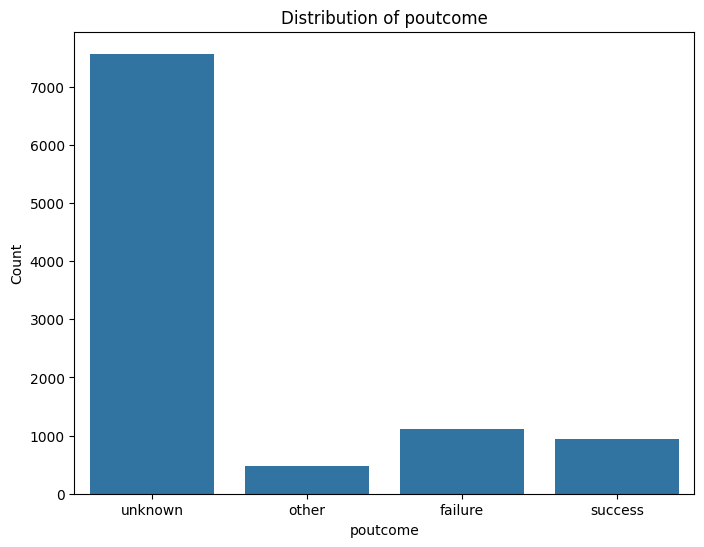

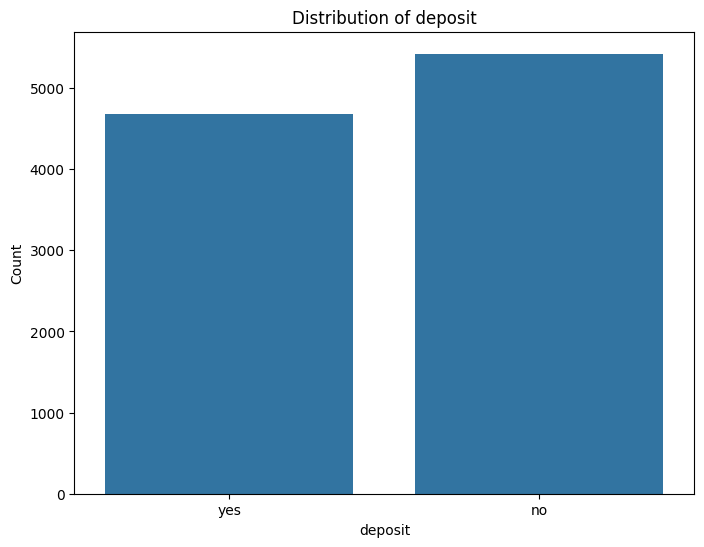

In [15]:
# рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
# ваш код
# постройте визуализации, иллюстрирующие результаты

# описательная статистика категориальных переменных 
cat_cols = df_3.describe(include=[object])
display(cat_cols)

print(f'Количество месяцев рекламной кампании: {df_3["month"].count()}')
print(f'Количество сфер занятости среди клиентов : {df_3["job"].nunique()}')

# графики распределения категорий выделенных признаков
for col in cat_cols.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_3, x=col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.show()

### Задание 6

In [16]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_3.groupby('poutcome')['deposit'].value_counts()

# превалирует в категориях other и success

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

### Задание 7

In [17]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Для каждого месяца необходимо рассчитать отношение отказов на общее количество принятых решений в этот месяц.

# группировка по признаку месяца и депозита
groupped = pd.crosstab(df_3['month'], df_3['deposit'])

# расчет доли отказов от депозита
groupped['total_deposit'] = groupped['no'] + groupped['yes']
groupped['no_rate'] = groupped['no'] / groupped['total_deposit']
groupped.sort_values(by='no_rate', ascending=False).head(1)

deposit,no,yes,total_deposit,no_rate
month,,,,
may,1776,841,2617,0.67864


### Задание 8

<Axes: xlabel='age_category,deposit'>

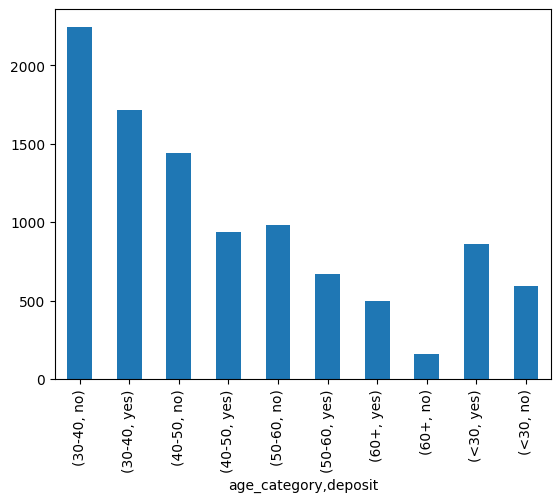

In [18]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

df_4 = df_3.copy()

# Функция для определения категории возраста
def age_category(age):
    if age < 30:
        return '<30'
    elif age >= 30 and age < 40:
        return '30-40'
    elif age >= 40 and age < 50:
        return '40-50'
    elif age >= 50 and age < 60:
        return '50-60'
    else:
        return '60+'

# применение функции
df_4['age_category'] = df_4['age'].apply(age_category)

# графики для визуализации распределения
df_4.groupby('age_category')['deposit'].value_counts().plot(kind='bar')

### Задания 9 и 10

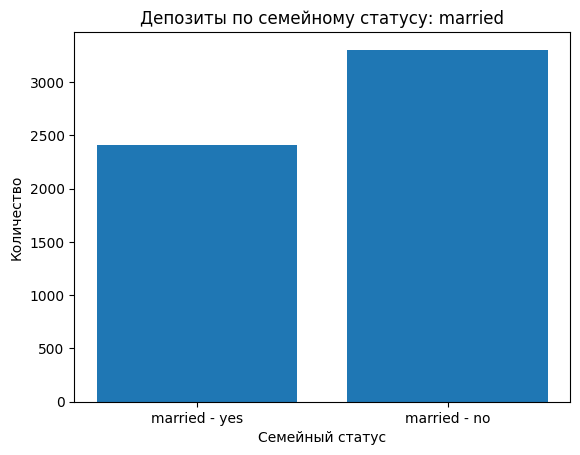

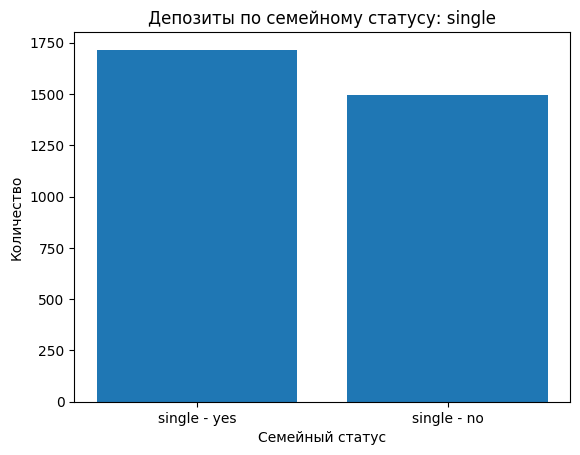

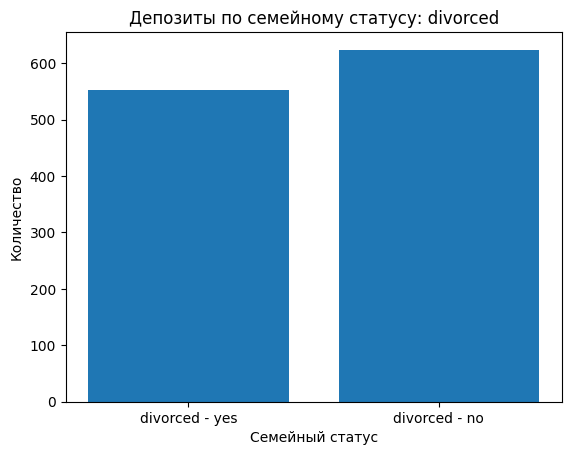

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Группируем данные по столбцу семейного статуса
grouped_data = df_4.groupby('marital')

for category in list(df_4['marital'].unique()):
    # Получаем данные для текущей категории
    data = grouped_data.get_group(category)

    # Подсчитываем количество открытых и неоткрытых депозитов
    yes_count = (data['deposit'] == 'yes').sum()
    no_count = (data['deposit'] == 'no').sum()

    # Построение графиков
    plt.bar([category + ' - yes', category + ' - no'], [yes_count, no_count])
    plt.xlabel('Семейный статус')
    plt.ylabel('Количество')
    plt.title(f'Депозиты по семейному статусу: {category}')
    plt.show()

Депозиты склонны оформлять одинокие по семейному статусу клиенты (single)

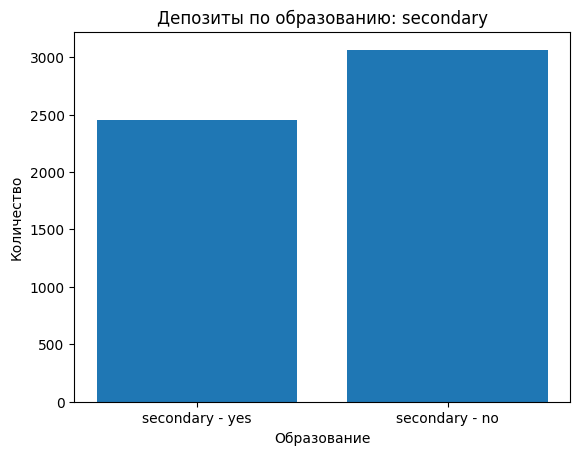

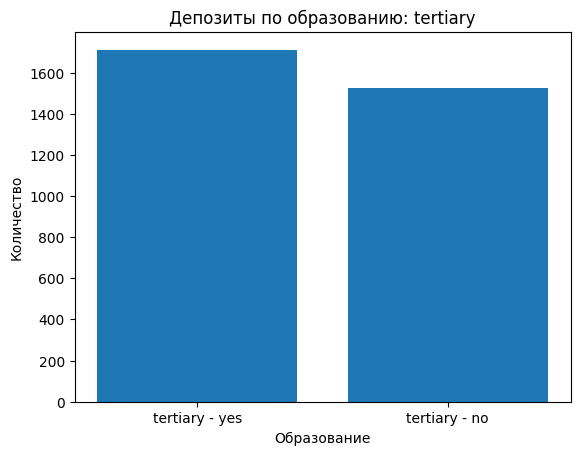

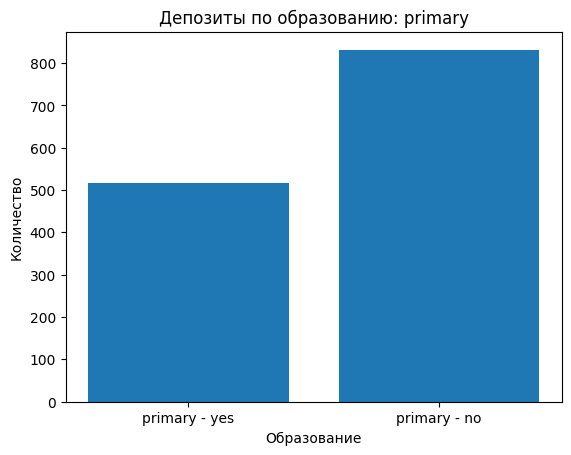

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# Группируем данные по столбцу education
grouped_data = df_4.groupby('education')

for category in list(df_4['education'].unique()):
    # Получаем данные для текущей категории
    data = grouped_data.get_group(category)

    # Подсчитываем количество открытых и неоткрытых депозитов
    yes_count = (data['deposit'] == 'yes').sum()
    no_count = (data['deposit'] == 'no').sum()

    # Построение графиков
    plt.bar([category + ' - yes', category + ' - no'], [yes_count, no_count])
    plt.xlabel('Образование')
    plt.ylabel('Количество')
    plt.title(f'Депозиты по образованию: {category}')
    plt.show()

Депозиты склонны оформлять клинты с образованием tertiary.

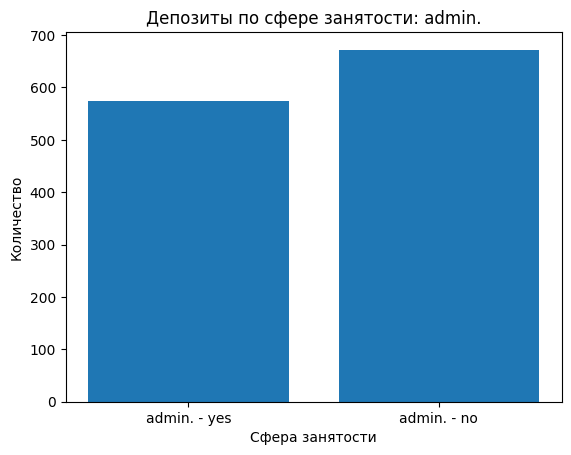

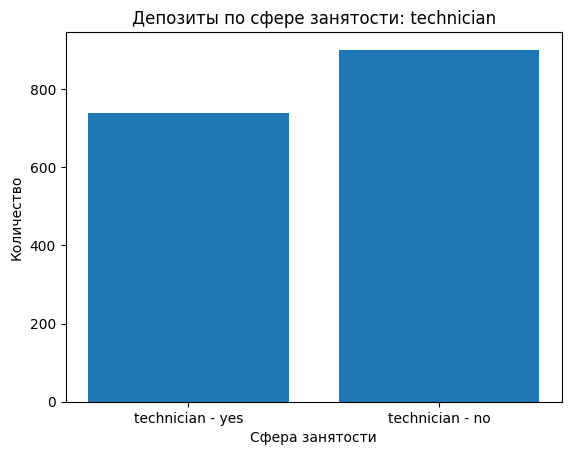

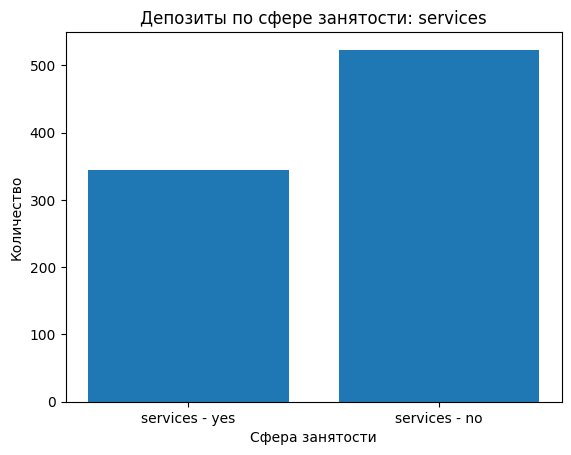

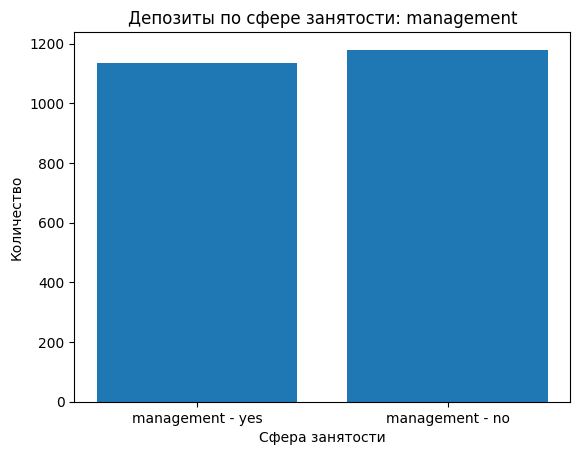

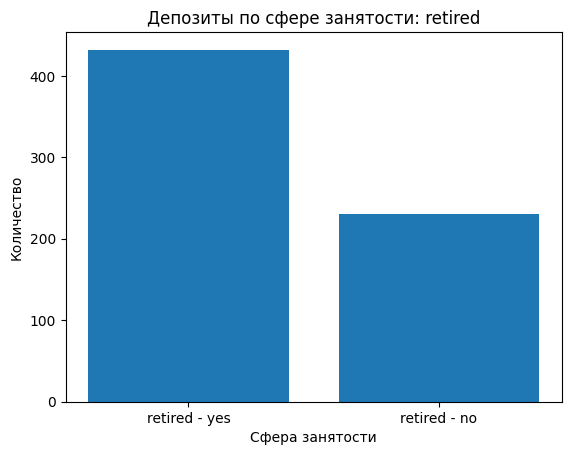

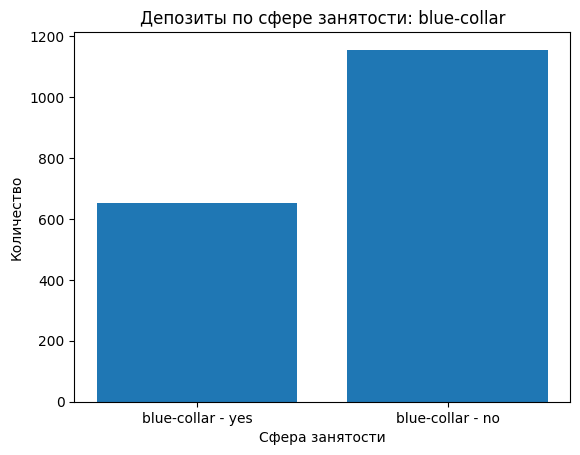

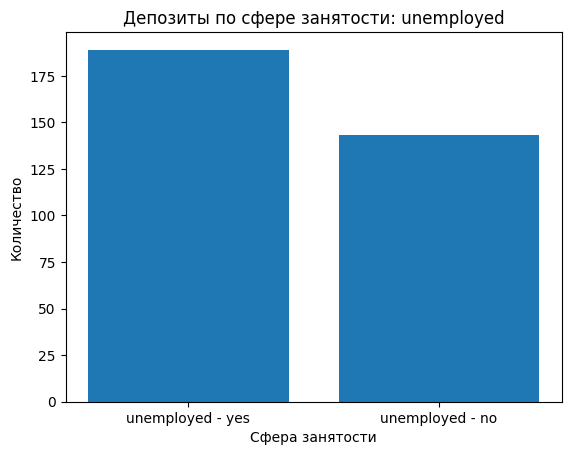

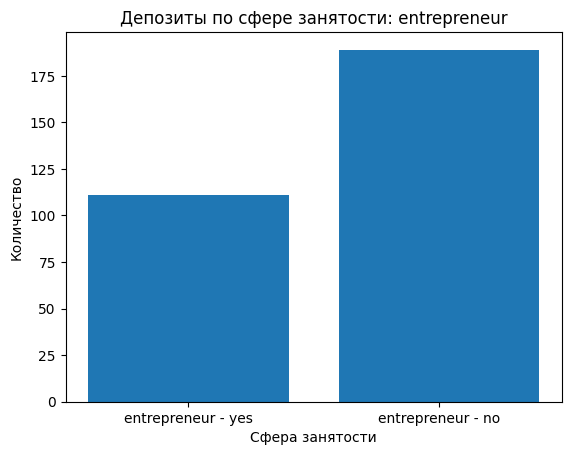

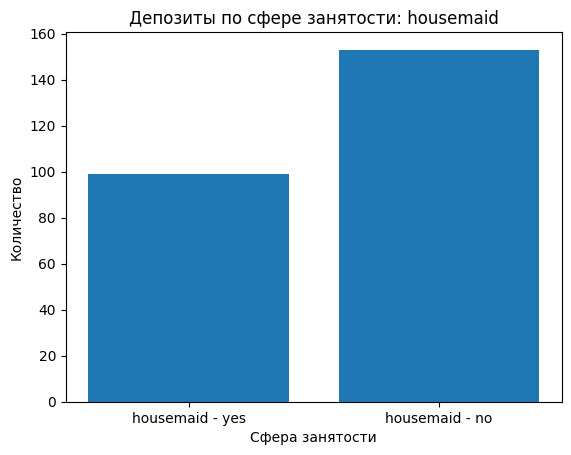

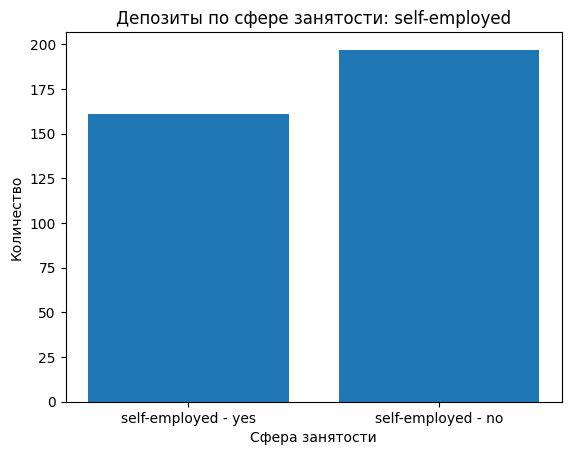

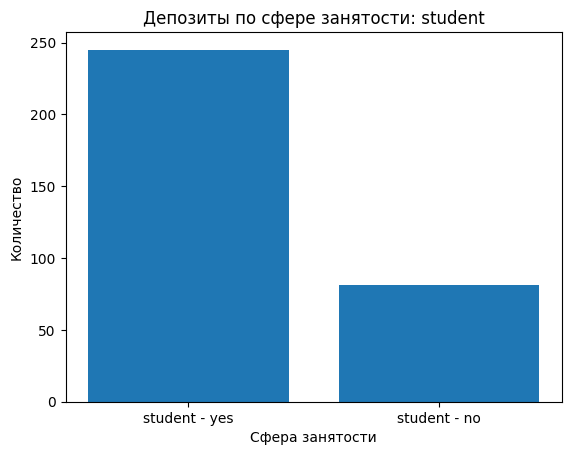

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

# Группируем данные по столбцу работы
grouped_data = df_4.groupby('job')

for category in list(df_4['job'].unique()):
    # Получаем данные для текущей категории
    data = grouped_data.get_group(category)

    # Подсчитываем количество открытых и неоткрытых депозитов
    yes_count = (data['deposit'] == 'yes').sum()
    no_count = (data['deposit'] == 'no').sum()

    # Построение графиков
    plt.bar([category + ' - yes', category + ' - no'], [yes_count, no_count])
    plt.xlabel('Сфера занятости')
    plt.ylabel('Количество')
    plt.title(f'Депозиты по сфере занятости: {category}')
    plt.show()

Депозиты склонны оформлять клиенты из сфер занятости unempoyed (не работают), retired (на пенсии) и student (учащиеся).

### Задание 11

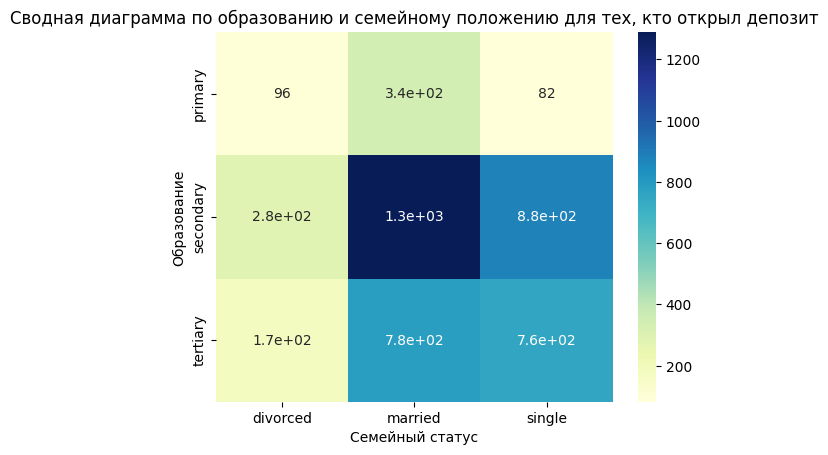

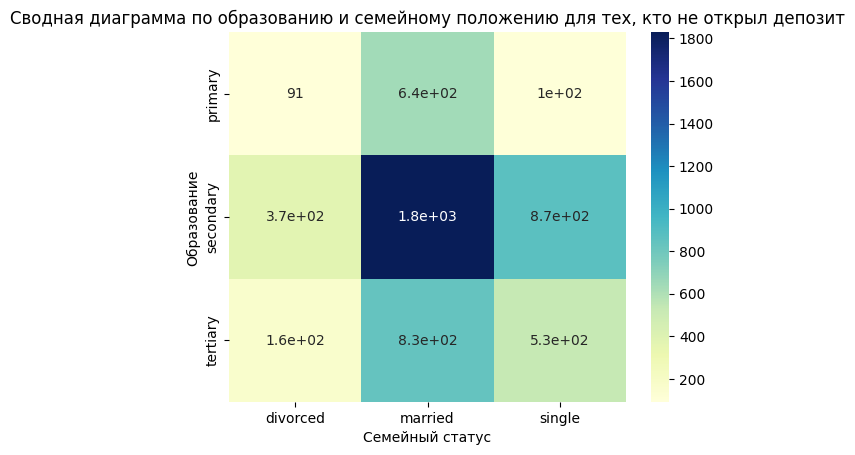

In [22]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

# Разделение таблицы на две части: для тех, кто открыл депозит, и для тех, кто не открыл
opened_deposit = df_4[df_4['deposit'] == 'yes']
not_opened_deposit = df_4[df_4['deposit'] == 'no']

# Построение сводной диаграммы для тех, кто открыл депозит
sns.heatmap(opened_deposit.pivot_table(index='education', columns='marital',
            aggfunc='size', fill_value=0), annot=True, cmap='YlGnBu')
plt.title(
    'Сводная диаграмма по образованию и семейному положению для тех, кто открыл депозит')
plt.xlabel('Семейный статус')
plt.ylabel('Образование')
plt.show()

# Построение сводной диаграммы для тех, кто не открыл депозит
sns.heatmap(not_opened_deposit.pivot_table(index='education',
            columns='marital', aggfunc='size', fill_value=0), annot=True, cmap='YlGnBu')
plt.title('Сводная диаграмма по образованию и семейному положению для тех, кто не открыл депозит')
plt.xlabel('Семейный статус')
plt.ylabel('Образование')
plt.show()

Больше всего клиентов на пересечении образования secondary  и married в обеих группах по депозиту.

## Часть 3: преобразование данных

### Задание 1

In [23]:
df_5 = df_4.copy()

In [24]:
# преобразуйте уровни образования

# Создаем объект LabelEncoder
label_encoder = LabelEncoder()
# Производим кодирование 
df_5['education_encoded'] = label_encoder.fit_transform(df_5['education'])

display(df_5.sample(5))
print(
    f'Сумма значений по закодированному столбцу образование: {df_5["education_encoded"].sum()}')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category,education_encoded
916,35,blue-collar,single,secondary,no,3623.0,no,no,telephone,30,oct,160,1,-1,0,unknown,yes,30-40,1
959,48,management,married,tertiary,no,2266.0,no,no,cellular,18,nov,676,1,-1,0,unknown,yes,40-50,2
7096,51,unemployed,divorced,secondary,no,-56.0,yes,no,cellular,19,nov,544,3,-1,0,unknown,no,50-60,1
10562,88,retired,married,primary,no,648.0,no,no,telephone,3,sep,318,1,-1,0,unknown,no,60+,0
1108,29,services,single,secondary,no,196.0,no,no,cellular,30,jan,726,2,-1,0,unknown,yes,<30,1


Сумма значений по закодированному столбцу образование: 11995


Ранее мы создали порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [25]:
# Кодирование переменной возраст
label_encoder = LabelEncoder()
df_5['age_encoded'] = label_encoder.fit_transform(df_5['age_category'])
display(df_5.sample(5))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category,education_encoded,age_encoded
10240,35,unemployed,single,secondary,no,2116.0,yes,no,cellular,13,may,409,2,-1,0,unknown,no,30-40,1,0
1290,28,technician,single,tertiary,no,2489.0,yes,no,telephone,27,feb,342,2,-1,0,unknown,yes,<30,2,4
9841,36,management,single,tertiary,no,171.0,no,no,unknown,17,jun,398,4,-1,0,unknown,no,30-40,2,0
1952,32,technician,single,tertiary,no,0.0,yes,yes,cellular,13,may,440,2,-1,0,unknown,yes,30-40,2,0
1940,33,blue-collar,single,primary,no,863.0,yes,no,telephone,13,may,622,3,-1,0,unknown,yes,30-40,0,0


### Задания 2 и 3

In [26]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# Создаем объект LabelBinarizer
label_binarizer = LabelBinarizer()
# Кодируем переменную депозит
df_5['deposit_encoded'] = label_binarizer.fit_transform(df_5['deposit'])
display(df_5.sample(5))
print(
    f'Стандартное отклонение новой переменной после кодировки: {round(df_5["deposit_encoded"].std(), 3)}')

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,deposit,age_category,education_encoded,age_encoded,deposit_encoded
5968,39,services,married,secondary,no,636.0,yes,no,telephone,12,...,15,1,-1,0,unknown,no,30-40,1,0,0
560,40,services,married,secondary,no,471.0,yes,no,cellular,24,...,430,4,-1,0,unknown,yes,40-50,1,1,1
11076,52,services,married,secondary,no,820.0,yes,no,cellular,2,...,135,2,-1,0,unknown,no,50-60,1,2,0
8845,37,housemaid,single,tertiary,no,561.0,no,no,cellular,18,...,188,1,165,2,failure,no,30-40,2,0,0
10602,52,blue-collar,married,secondary,no,665.0,yes,no,unknown,15,...,57,4,-1,0,unknown,no,50-60,1,2,0


Стандартное отклонение новой переменной после кодировки: 0.499


In [27]:
# Аналогично кодируем и другие категориальные переменные 
df_5['default_encoded'] = label_binarizer.fit_transform(df_5['default'])
df_5['housing_encoded'] = label_binarizer.fit_transform(df_5['housing'])
df_5['loan_encoded'] = label_binarizer.fit_transform(df_5['loan'])
display(df_5.sample(5))

,age,job,marital,education,default,balance,housing,loan,contact,day,...,previous,poutcome,deposit,age_category,education_encoded,age_encoded,deposit_encoded,default_encoded,housing_encoded,loan_encoded
91,47,blue-collar,married,secondary,no,863.0,yes,no,unknown,19,...,0,unknown,yes,40-50,1,1,1,0,1,0
6740,23,housemaid,single,primary,no,93.0,yes,no,cellular,18,...,0,unknown,no,<30,0,4,0,0,1,0
7136,38,housemaid,married,secondary,no,0.0,yes,no,cellular,23,...,0,unknown,no,30-40,1,0,0,0,1,0
3058,55,admin.,married,secondary,no,1633.0,no,no,cellular,11,...,2,success,yes,50-60,1,2,1,0,0,0
10417,25,admin.,single,tertiary,no,1734.0,no,no,cellular,19,...,0,unknown,no,<30,2,4,0,0,0,0


Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

In [28]:
# Вычисление суммы
sum = df_5['default_encoded'].mean() + df_5['housing_encoded'].mean() + \
    df_5['loan_encoded'].mean()
round(sum, 3)

0.635

### Задание 4

In [29]:
# создайте дамми-переменные
df_5 = pd.get_dummies(
    df_5, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
display(df_5.sample(5))
df_5.shape

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
1105,60,tertiary,no,-71.0,yes,yes,30,1451,1,-1,...,False,False,False,False,False,False,False,False,False,True
8820,30,secondary,no,384.0,no,no,25,73,3,-1,...,False,False,False,False,False,False,False,False,False,True
6758,35,secondary,no,260.0,yes,no,13,155,6,-1,...,False,False,True,False,False,False,False,False,False,True
10384,58,secondary,no,2.0,no,no,16,684,1,-1,...,True,False,False,False,False,False,False,False,False,True
3721,28,secondary,no,205.0,no,no,14,87,3,184,...,False,False,False,False,False,False,False,True,False,False


(10105, 52)

In [30]:
# Отбираем только зкодированные и обработанные признаки

df_6 = df_5.copy()
df_6.drop(['age_category', 'deposit', 'loan', 'housing',
          'default', 'education', 'age'], axis=1, inplace=True)
display(df_6.head())
df_6.shape

,balance,day,duration,campaign,pdays,previous,education_encoded,age_encoded,deposit_encoded,default_encoded,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2343.0,5,1042,1,-1,0,1,2,1,0,...,False,False,True,False,False,False,False,False,False,True
1,45.0,5,1467,1,-1,0,1,2,1,0,...,False,False,True,False,False,False,False,False,False,True
2,1270.0,5,1389,1,-1,0,1,1,1,0,...,False,False,True,False,False,False,False,False,False,True
3,2476.0,5,579,1,-1,0,1,2,1,0,...,False,False,True,False,False,False,False,False,False,True
4,184.0,5,673,2,-1,0,2,2,1,0,...,False,False,True,False,False,False,False,False,False,True


(10105, 45)

### Задания 5 и 6

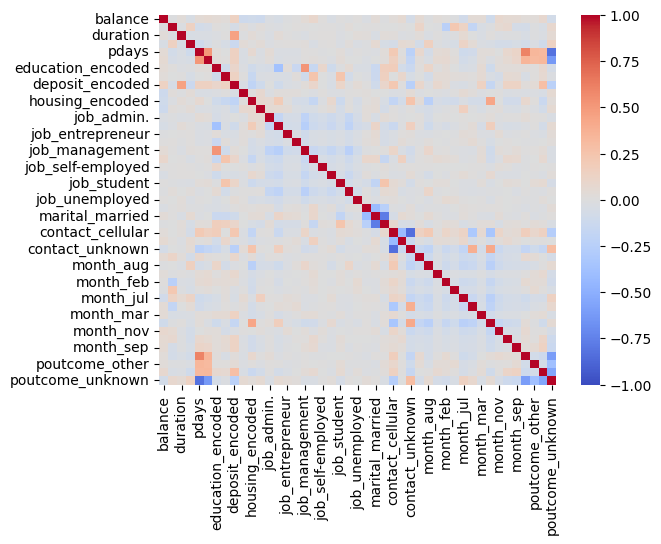

In [31]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

corr_matrix = df_6.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.show()

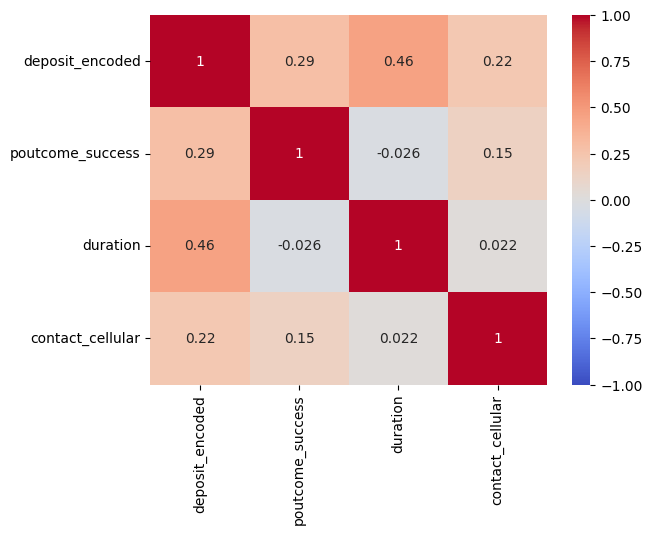

In [32]:
# для более прицельной оценки степени корреляции построим более маленькую тепловую карту по выделенным признакам
corr_matrix_2 = df_6[['deposit_encoded', 'poutcome_success',
                      'duration', 'contact_cellular']].corr()
sns.heatmap(corr_matrix_2, cmap='coolwarm',
            annot=True, vmin=-1, vmax=1, center=0)
plt.show()

In [33]:
corr_matrix[[corr_matrix >= 0.9 and corr_matrix > 1]].notna().sum()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [35]:
# Есть ли среди признаков мультиколлинеарность?
# Будем считать достаточно сильной корреляцию не менее 0.9.

# Ищем значения больше 0.9, но меньше 1
mask = (corr_matrix >= 0.9) & (corr_matrix > 1)
filtered_corr_matrix = corr_matrix[mask]
filtered_corr_matrix.notna().sum()
# сильной мультиколлинеарности нет

balance              0
day                  0
duration             0
campaign             0
pdays                0
previous             0
education_encoded    0
age_encoded          0
deposit_encoded      0
default_encoded      0
housing_encoded      0
loan_encoded         0
job_admin.           0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
marital_divorced     0
marital_married      0
marital_single       0
contact_cellular     0
contact_telephone    0
contact_unknown      0
month_apr            0
month_aug            0
month_dec            0
month_feb            0
month_jan            0
month_jul            0
month_jun            0
month_mar            0
month_may            0
month_nov            0
month_oct            0
month_sep            0
poutcome_failure     0
poutcome_other       0
poutcome_su

### Задания 7 и 8

In [36]:
# Разделяем датасет на факторы и целевую переменную
X = df_6.drop(['deposit_encoded'], axis=1)
y = df_6['deposit_encoded']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=42,
    test_size=0.33
)

In [37]:
# рассчитайте необходимые показатели

print(f'Размер тестовой выборки: {X_test.shape}')
print(
    f'Среднее значение целевой переменной на тестовой выборке: {round(y_test.mean(),2)}')

Размер тестовой выборки: (3335, 44)
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [38]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# Создаем объект SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
# Обучение и отбор признаков модели на тренировочной выборке
X_train_new = selector.fit_transform(X_train, y_train)
mask = selector.get_support()
# Сохраняем названия самых значимых столбцов
X_train_selected = X_train.columns[mask]
print(X_train_selected)

Index(['balance', 'duration', 'campaign', 'pdays', 'previous', 'age_encoded',
       'housing_encoded', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [39]:
# Сохраняем датасеты в формате DataFrame с маской отобранных признаков
X_train_selected_df = pd.DataFrame(X_train_new, columns=X_train.columns[mask])
X_test_selected_df = pd.DataFrame(X_test, columns=X_train.columns[mask])
X_train_selected_df.head()

,balance,duration,campaign,pdays,previous,age_encoded,housing_encoded,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,557.0,513.0,1.0,-1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,69.0,296.0,1.0,205.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,399.0,2.0,358.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,444.0,137.0,1.0,102.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1444.0,100.0,1.0,117.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Задание 10

In [40]:
# нормализуйте данные с помощью minmaxsxaler

# Создаем объект MinMaxScaler
scaler = MinMaxScaler()
# Нормализация данных 
X_train_norm = scaler.fit_transform(X_train_selected_df)
X_test_norm = scaler.transform(X_test_selected_df)

print(
    f'Среднее арифметическое для первого предиктора из тестовой выборки: {round(np.mean(X_test_norm[:, 0]),2)}')

Среднее арифметическое для первого предиктора из тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [41]:
# обучите логистическую регрессию и рассчитайте метрики качества

# Создаём объект класса LogisticRegression с заданными параметрами
log_reg = linear_model.LogisticRegression(
    random_state=42,
    solver='sag',
    max_iter=1000
)

# Обучение модели
log_reg.fit(X_train_norm, y_train)

# Предсказание класса
lr_train_predict = log_reg.predict(X_train_norm)
lr_test_predict = log_reg.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тренировочной выборки')
print(metrics.classification_report(y_train, lr_train_predict))
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, lr_test_predict))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Модель хорошо обучена, переобучеия нет

### Задания 2,3,4

In [42]:
# обучите решающие деревья, настройте максимальную глубину

# Создаём объект класса DecisionTreeClassifier с заданными параметрами
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
# Обучение модели
dt.fit(X_train_norm, y_train)
# Предсказание целевого признака
dt_train_predict = dt.predict(X_train_norm)
dt_test_predict = dt.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тренировочной выборки')
print(metrics.classification_report(y_train, dt_train_predict))
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, dt_test_predict))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Модель по качеству предсказания на тестовой выборке отстает от предыдущей модели логистической регрессии, мы видим переобучение модели. 

Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

Лучшая максимальная глубина: 6


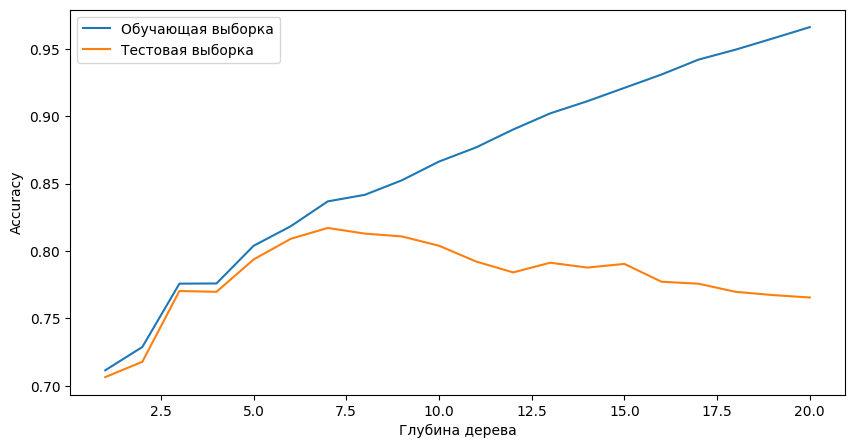

In [44]:
# Диапазон глубин деревьев для перебора
max_depths = range(1, 21)
best_depth = None
best_accuracy = 0
threshold = 0.01 

# Значения accuracy 
train_accuracies = []
test_accuracies = []

# Цикл для подбора лучшего значения глубины
for depth in max_depths:
    # Создание и обучение модели
    dt = tree.DecisionTreeClassifier(
        criterion='entropy', max_depth=depth, random_state=42)
    dt.fit(X_train_norm, y_train)

    # Предсказания для обучающей выборки
    y_train_pred = dt.predict(X_train_norm)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Предсказания для тестовой выборки
    y_test_pred = dt.predict(X_test_norm)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

    # Проверка на переобучение и обновление лучшей глубины
    if test_accuracy > best_accuracy and (train_accuracy - test_accuracy) < threshold:
        best_accuracy = test_accuracy
        best_depth = depth

# Вывод лучшей глубины
print(f'Лучшая максимальная глубина: {best_depth}')

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_accuracies, label='Обучающая выборка')
plt.plot(max_depths, test_accuracies, label='Тестовая выборка')
plt.xlabel('Глубина дерева')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
# обучите решающие деревья, настройте максимальную глубину

# Создаём объект класса DecisionTreeClassifier с новыми параметрами
dt_2 = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=best_depth
)
# Обучение модели
dt_2.fit(X_train_norm, y_train)
# Предсказание целевого признака 
dt_2_train_predict = dt_2.predict(X_train_norm)
dt_2_test_predict = dt_2.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тренировочной выборки')
print(metrics.classification_report(y_train, dt_2_train_predict))
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, dt_2_test_predict))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



После подбора параметров модель стала довольно хорошо предсказывать целевой признак, чуть лучше модели логистической регрессии, переобучения нет. 

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Задаем словарь с параметрами для перебора
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создаем модель DecisionTreeClassifier
dt_3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(dt_3, param_grid, scoring='f1')

# Обучение модели GridSearchCV для поиска лучших параметров
grid_search.fit(X_train_norm, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучшая точность: {grid_search.best_score_}')

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
Лучшая точность: 0.7962156923133622


In [46]:
# Создаем модель DecisionTreeClassifier с новыми подобранными параметрами
dt_4 = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=7,
    min_samples_split=10
)
# Обучение модели
dt_4.fit(X_train_norm, y_train)
# Предсказание 
dt_4_train_predict = dt_4.predict(X_train_norm)
dt_4_test_predict = dt_4.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тренировочной выборки')
print(metrics.classification_report(y_train, dt_4_train_predict))
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, dt_4_test_predict))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.83      0.84      0.83      6770
weighted avg       0.84      0.84      0.84      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Благодаря еще одному методу подбора гиперпараметров удалось еще чуть-чуть улучшить предсказание целевого признака с помощью модели деревьев решений. 

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [47]:
# обучите на ваших данных случайный лес

# Создаем модель RandomForestClassifier с заданными параметрами
random_forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
# Обучаем модель
random_forest_model.fit(X_train_norm, y_train)

# Предсказание класса
rf_train_pred = random_forest_model.predict(X_train_norm)
rf_test_pred = random_forest_model.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тренировочной выборки')
print(metrics.classification_report(y_train, rf_train_pred))
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, rf_test_pred))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Данная модель случайного леса не уступает предыдущей модели деревьев решений с подбором гиперпарамтеров на тестовой выборке.

### Задания 2 и 3

In [48]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Параметры для модели
params = {
    'learning_rate': 0.05,
    'n_estimators': 300,
    'min_samples_leaf': 5,
    'max_depth': 5,
    'random_state': 42
}

# Create the gradient boosting classifier
gb_model = GradientBoostingClassifier(**params)
gb_model.fit(X_train_norm, y_train)

# Делаем предсказание класса
gb_train_pred = gb_model.predict(X_train_norm)
gb_test_pred = gb_model.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тренировочной выборки')
print(metrics.classification_report(y_train, gb_train_pred))
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, gb_test_pred))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Модель градиентного бустинга незначительно улучшила результаты предсказания по сравнению с моделью случайного леса на тестовой выборке.

### Задание 4

In [49]:
# объедините уже известные вам алгоритмы с помощью стекинга

# Объединяем предыдущие предсказания всех моделей
base_predictions = np.column_stack(
    (lr_test_predict, dt_4_test_predict, rf_test_pred, gb_test_pred))

# Обучение модели логистической регрессии как мета-модели
lr_meta_model = linear_model.LogisticRegression(
    random_state=42, 
    solver='sag', 
    max_iter=1000
    )
lr_meta_model.fit(base_predictions, y_test)

# Предсказание целевого признака с помощью мета-модели
meta_predictions = lr_meta_model.predict(base_predictions)

In [53]:
# Оценка метрики precision на тестовой выборке

print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, meta_predictions))

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Мета-модель имеет самый высокий показатель метрики precision на тестовой выборке по сравнению с ранее построенными отдельными модели. 

### Задание 5

In [51]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

importances = gb_model.feature_importances_
X_train_df = pd.DataFrame(X_train_norm, columns=X_train_selected_df.columns)

# Создание списка пар "значение важности" - "имя признака"
feature_importances = [(importance, feature) for feature,
                       importance in zip(X_train_df.columns, importances)]

# Сортировка списка по значению важности
feature_importances = sorted(
    feature_importances, key=lambda x: x[0], reverse=True)

# Вывод списка пар "значение важности" - "имя признака"
for importance, feature in feature_importances:
    print(f"{feature}: {importance:.2f}")

duration: 0.50
poutcome_success: 0.12
contact_unknown: 0.07
balance: 0.06
pdays: 0.06
housing_encoded: 0.05
age_encoded: 0.04
month_mar: 0.03
month_oct: 0.02
campaign: 0.02
month_may: 0.01
month_sep: 0.01
previous: 0.01
contact_cellular: 0.00
poutcome_unknown: 0.00


### Задания 6,7,8

In [52]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

# Функция для оптимизации гиперпараметров для модели случайного леса 
def objective(trial):
    # Параметры для перебора
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создание модели случайного леса 
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    # Обучение модели 
    model.fit(X_train_selected_df, y_train)
    # Оценка метрики accuracy
    accuracy = model.score(X_test_norm, y_test)
    return accuracy

In [ ]:
# Обучение и подбор гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-19 18:23:42,690] A new study created in memory with name: no-name-ee2c737d-5203-44f7-a06d-b700e5e8894f
[I 2024-04-19 18:23:44,986] Trial 0 finished with value: 0.543328335832084 and parameters: {'n_estimators': 192, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.543328335832084.
[I 2024-04-19 18:23:46,824] Trial 1 finished with value: 0.5481259370314843 and parameters: {'n_estimators': 195, 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.5481259370314843.
[I 2024-04-19 18:23:48,873] Trial 2 finished with value: 0.5445277361319341 and parameters: {'n_estimators': 148, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.5481259370314843.
[I 2024-04-19 18:23:49,960] Trial 3 finished with value: 0.5544227886056972 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.5544227886056972.
[I 2024-04-19 18:23:51,683] Trial 4 finished with value: 0.5379310344827586 

In [ ]:
best_params = study.best_params
print(f"Лучшие гиперпараметры: {best_params}")

Лучшие гиперпараметры: {'n_estimators': 145, 'max_depth': 22, 'min_samples_leaf': 9}
Лучшая точность: 0.5652173913043478


In [ ]:
# Создаем модель случайного леса в подобранными гиперпараметрами
rf_2_model = ensemble.RandomForestClassifier(
    n_estimators=135,
    max_depth=22,
    criterion='gini',
    min_samples_leaf=6,
    random_state=42
)
# Обучение модели
rf_2_model.fit(X_train_norm, y_train)

# Предсказание класса
rf_2_train_pred = rf_2_model.predict(X_train_norm)
rf_2_test_pred = rf_2_model.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, rf_2_test_pred))

Расчет метрик для тренировочной выборки
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3634
           1       0.84      0.88      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



По сравнению с мета-моделью по метрике precision данная модель незначительно уступает. По метрике recall данная модель лучше. 

# Дополнительное задание

На этапе №6, после выполнения задания 6.5, применить новый метод оптимизации гиперпараметров (помимо Optuna). В тетради с реализацией модели сравнить полученные результаты с базовой моделью.

In [55]:
# Определение сетки параметров для Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_leaf': [2, 5, 10]
}

# Создание объекта GridSearchCV с моделью Random Forest Classifier
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid, cv=5, scoring='accuracy')

# Обучение модели
grid_search.fit(X_train_norm, y_train)

# Получение лучших гиперпараметров и модели
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Оценка производительности модели на тестовом наборе данных
test_accuracy = best_model.score(X_test_norm, y_test)

print(f"Лучшие гиперпараметры: {best_params}")
print(f"Точность на валидационном наборе данных: {test_accuracy}")

Лучшие гиперпараметры: {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 200}
Точность на валидационном наборе данных: 0.8287856071964018


In [56]:
# Создание модели RandomForestClassifier с подобранными параметрами
rf_3_model = ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=2,
    random_state=42
)
# Обучение модели
rf_3_model.fit(X_train_norm, y_train)

# Предсказание класса
rf_3_train_pred = rf_3_model.predict(X_train_norm)
rf_3_test_pred = rf_3_model.predict(X_test_norm)

# Расчет метрик
print('Расчет метрик для тестовой выборки')
print(metrics.classification_report(y_test, rf_3_test_pred))

Расчет метрик для тестовой выборки
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Данная модель по значениям метрик на тестовой выборке аналогична предыдущей модели случайного леса с подбором параметров с помощью Optuna и, соответственно, также лучше, чем предыдщуие модели. 